# Demo for Classification Model Task

The current notebook is going to be a demo of the classification model capabilities, while also being used as the initial steps for the creation of the pipeline of the deployed version.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pickle, joblib
sys.path.insert(0, '..')

import support_functions

## Simple Mock Gait Cycle data from Gyroscope

In [2]:

def simulate_custom_gait_signal(duration_sec: int=60 , fs: int=100, freq: int=1.2, stroke: bool=False, noise_std: float=0.05):
    '''
    Simulate custom gait signals for stroke and healthy individuals.
    Args:
        duration_sec (int): Duration of the signal in seconds.
        fs (int): Sampling frequency in Hz.
        freq (float): Frequency of the sine wave.
        stroke (bool): If True, simulate stroke condition.
        noise_std (float): Standard deviation of the noise.
    '''
    t = np.linspace(0, duration_sec, int(duration_sec * fs))
    
    # Define target peak values
    if stroke:
        max_val   = 300
        amp_right = 200
    else:
        max_val   = 450
        amp_right = 420
    
    # Simulate left and right signals (right affected in stroke)
    left_z  = (max_val / 2) * np.sin(2 * np.pi * freq * t) + np.random.normal(0, noise_std * max_val, size=t.shape)
    right_z = (amp_right / 2) * np.sin(2 * np.pi * freq * t + (0.2 if stroke else 0)) + np.random.normal(0, noise_std * amp_right, size=t.shape)

    # Return DataFrame
    dataframe = pd.DataFrame({
        'timestamp (+0700)': pd.date_range('2024-01-01 00:00:00', periods=len(t), freq=f'{int(1000/fs)}ms'),
        'left-z-axis (deg/s)': left_z,
        'right-z-axis (deg/s)': right_z
    })
    return dataframe

## Load the Linear Regression Classification Model 

In [3]:
# Load the model and the scaler
model = joblib.load('/Users/stamatiosorphanos/Documents/GaitRehab/models/classification_logistic_regression.pkl')
scaler = joblib.load('/Users/stamatiosorphanos/Documents/GaitRehab/models/classification_scaler.pkl')

print('Input features:', model.n_features_in_)
print('Classes:', model.classes_)

Input features: 4
Classes: [0 1]


### Healthy Subject Prediction 

In [4]:
# Create the mock raw gyroscope data, get the features we use during the training and scale them for prediction
healthy_df = simulate_custom_gait_signal(stroke=False)
print('The mock raw Gyroscope data is:', healthy_df.head())

# Get the features used for training min, max for the z-axis of the gyroscope
raw_features = support_functions.time_domain_features(healthy_df)
print('\nRaw input features:', raw_features)


# Scale the features
raw_dict = {'right-z-axis-(deg/s)-min': [raw_features[0]], 'left-z-axis-(deg/s)-min' : [raw_features[1]], 
            'right-z-axis-(deg/s)-max': [raw_features[2]], 'left-z-axis-(deg/s)-max' : [raw_features[3]]}
raw_data = pd.DataFrame(raw_dict)
X_input = scaler.transform(raw_data)
print('\nScaled input features:', X_input)

# Predict the class and the probability of asymmetry
y_pred = model.predict(X_input)[0]
y_prob = model.predict_proba(X_input)[0][1] 

print(f'Predicted class: {y_pred} — Probability of asymmetry: {y_prob:.2f} - Probability of symmetry: {1-y_prob:.2f}')

The mock raw Gyroscope data is:         timestamp (+0700)  left-z-axis (deg/s)  right-z-axis (deg/s)
0 2024-01-01 00:00:00.000           -12.296330             -4.506669
1 2024-01-01 00:00:00.010            15.834334             26.915808
2 2024-01-01 00:00:00.020            24.857655             27.889910
3 2024-01-01 00:00:00.030            45.670391             46.575251
4 2024-01-01 00:00:00.040            28.219858             40.144073

Raw input features: [-277.56052401007287, -295.6008171931865, 269.73617883643817, 302.3783815560361]

Scaled input features: [[-0.81384826 -1.03705655 -0.60160447 -0.59308207]]
Predicted class: 0 — Probability of asymmetry: 0.44 - Probability of symmetry: 0.56


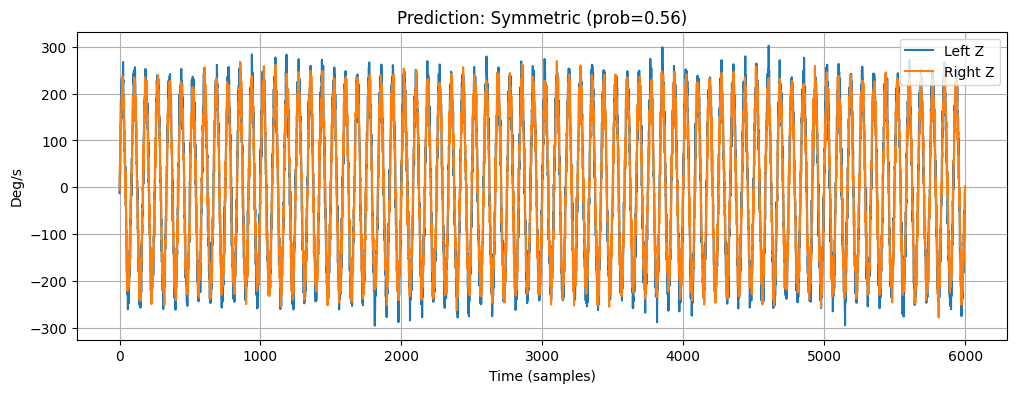

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(healthy_df['left-z-axis (deg/s)'], label='Left Z')
plt.plot(healthy_df['right-z-axis (deg/s)'], label='Right Z')
plt.title(f"Prediction: {'Asymmetric' if y_pred == 1 else 'Symmetric'} (prob={1-y_prob:.2f})")
plt.xlabel('Time (samples)')
plt.ylabel('Deg/s')
plt.legend()
plt.grid(True)
plt.show()

### Stroke Subject Prediction 

In [6]:
# Create the mock raw gyroscope data, get the features we use during the training and scale them for prediction
stroke_df = simulate_custom_gait_signal(stroke=True)
print('The mock raw Gyroscope data is:', stroke_df.head())

# Get the features used for training min, max for the z-axis of the gyroscope
raw_features = support_functions.time_domain_features(stroke_df)
print('\nRaw input features:', raw_features)


# Scale the features
raw_dict = {'right-z-axis-(deg/s)-min': [raw_features[0]], 'left-z-axis-(deg/s)-min' : [raw_features[1]], 
            'right-z-axis-(deg/s)-max': [raw_features[2]], 'left-z-axis-(deg/s)-max' : [raw_features[3]]}
raw_data = pd.DataFrame(raw_dict)
X_input = scaler.transform(raw_data)
print('\nScaled input features:', X_input)

# Predict the class and the probability of asymmetry
y_pred = model.predict(X_input)[0]
y_prob = model.predict_proba(X_input)[0][1] 

print(f'Predicted class: {y_pred} — Probability of asymmetry: {y_prob:.2f} - Probability of symmetry: {1-y_prob:.2f}')

The mock raw Gyroscope data is:         timestamp (+0700)  left-z-axis (deg/s)  right-z-axis (deg/s)
0 2024-01-01 00:00:00.000            22.183014             33.357962
1 2024-01-01 00:00:00.010            16.765434             13.522393
2 2024-01-01 00:00:00.020            17.462933             61.482914
3 2024-01-01 00:00:00.030            30.309261             51.720814
4 2024-01-01 00:00:00.040            54.561528             56.050817

Raw input features: [-125.50564929844316, -188.75802809209614, 126.2497359528763, 198.7410443671777]

Scaled input features: [[ 1.0657141   0.4299426  -1.95396074 -1.84125345]]
Predicted class: 1 — Probability of asymmetry: 0.99 - Probability of symmetry: 0.01


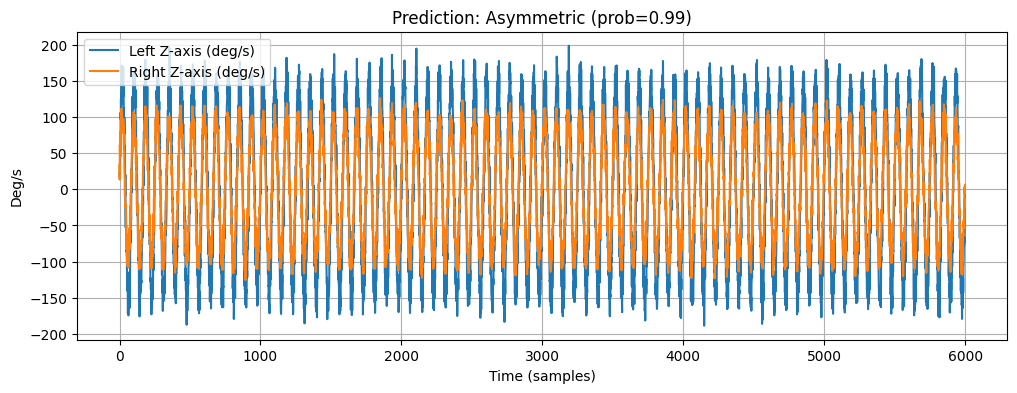

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(stroke_df['left-z-axis (deg/s)'], label='Left Z-axis (deg/s)')
plt.plot(stroke_df['right-z-axis (deg/s)'], label='Right Z-axis (deg/s)')
plt.title(f"Prediction: {'Asymmetric' if y_pred == 1 else 'Symmetric'} (prob={y_prob:.2f})")
plt.xlabel('Time (samples)')
plt.ylabel('Deg/s')
plt.legend()
plt.grid(True)
plt.show()